In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import os
import random
from collections import defaultdict
from sam.sam import SAM as SAM_Wrapper
from sam.example.utility.bypass_bn import enable_running_stats, disable_running_stats
import json
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Make CUDA ops deterministic where possible
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generator seeded for deterministic splits
_gen = torch.Generator()
_gen.manual_seed(SEED)

# Ensure random_split uses the seeded generator by default
_orig_random_split = random_split
def random_split(dataset, lengths, generator=None):
    return _orig_random_split(dataset, lengths, generator=generator if generator is not None else _gen)

# Loading Dataset (PACS)

In [6]:
class Identity(nn.Module):
    """An identity layer"""
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
class ResNet(torch.nn.Module):
    """ResNet with the softmax chopped off and the batchnorm frozen"""
    def __init__(self, input_shape, hparams):
        super(ResNet, self).__init__()
        if hparams['resnet18']:
            self.network = torchvision.models.resnet18(pretrained=True)
            self.n_outputs = 512
        else:
            self.network = torchvision.models.resnet50(pretrained=True)
            self.n_outputs = 2048

        # self.network = remove_batch_norm_from_resnet(self.network)

        # adapt number of channels
        nc = input_shape[0]
        if nc != 3:
            tmp = self.network.conv1.weight.data.clone()

            self.network.conv1 = nn.Conv2d(
                nc, 64, kernel_size=(7, 7),
                stride=(2, 2), padding=(3, 3), bias=False)

            for i in range(nc):
                self.network.conv1.weight.data[:, i, :, :] = tmp[:, i % 3, :, :]

        # save memory
        del self.network.fc
        self.network.fc = Identity()

        if hparams["freeze_bn"]:
            self.freeze_bn()
        self.hparams = hparams
        self.dropout = nn.Dropout(hparams['resnet_dropout'])
        self.activation = nn.Identity() # for URM; does not affect other algorithms

    def forward(self, x):
        """Encode x into a feature vector of size n_outputs."""
        return self.activation(self.dropout(self.network(x)))

    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super().train(mode)
        if self.hparams["freeze_bn"]:
            self.freeze_bn()

    def freeze_bn(self):
        for m in self.network.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()



def Featurizer(input_shape, hparams):
    """Auto-select an appropriate featurizer for the given input shape."""
    if input_shape[1:3] == (224, 224):
        return ResNet(input_shape, hparams)
    else:
        raise NotImplementedError


def Classifier(in_features, out_features, is_nonlinear=False):
    if is_nonlinear:
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features // 2, in_features // 4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features // 4, out_features))
    else:
        return torch.nn.Linear(in_features, out_features)

class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.

        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [7]:
MODEL_DIR = '/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models'

In [8]:
DIR_PHOTO = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [9]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name],
                                domain
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, domain = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, domain

In [10]:
TRAIN_DOMAINS = ['photo', 'art_painting', 'cartoon']
TEST_DOMAINS = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TRAIN_DOMAINS,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TEST_DOMAINS,
    transform=transform
)

In [11]:
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ALTERNATIVELY DO NOT CREATE A VALIDATION SPLIT
pacs_train_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(TEST_DOMAINS)}")

Training on 6062 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [12]:
pacs_source_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

pacs_photo = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['photo'],transform=transform)
pacs_photo_loader = DataLoader(pacs_photo, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_art_painting = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['art_painting'],transform=transform)
pacs_art_painting_loader = DataLoader(pacs_art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_cartoon = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['cartoon'],transform=transform)
pacs_cartoon_loader = DataLoader(pacs_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Helper Functions

In [23]:
def compute_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.predict(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

# 1) ERM Baseline

In [24]:
class ERM(Algorithm):
    """
    Empirical Risk Minimization (ERM)
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = Featurizer(input_shape, self.hparams)
        self.classifier = Classifier(
            self.featurizer.n_outputs,
            num_classes,
            self.hparams['nonlinear_classifier'])
        self.network = nn.Sequential(self.featurizer, self.classifier)
        
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [25]:
ERM_PATH = '/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training'
ERM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
ERM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for model_suffix, model_name in zip(ERM_MODELS, ERM_NAMES):
    checkpoint_path = os.path.join(ERM_PATH, f'model{model_suffix}.pkl')
    checkpoint = torch.load(checkpoint_path)
    ERM_Model = ERM(input_shape=checkpoint['model_input_shape'],
                    num_classes=checkpoint['model_num_classes'],
                    num_domains=checkpoint['model_num_domains'],
                    hparams=checkpoint['model_hparams'])
    ERM_Model.load_state_dict(checkpoint["model_dict"])
    ERM_Model.to(DEVICE)
    
    print(f"Loading ERM model: {model_name}")
    print("\tTarget Domain Evaluation:")
    sketch_accuracy = compute_accuracy(ERM_Model, pacs_test_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
    
    print("\tSource Domain Evaluation:")
    source_accuracy_erm = compute_accuracy(ERM_Model, pacs_source_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

    source_photo_accuracy_erm = compute_accuracy(ERM_Model, pacs_photo_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

    source_art_painting_accuracy_erm = compute_accuracy(ERM_Model, pacs_art_painting_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

    source_cartoon_accuracy_erm = compute_accuracy(ERM_Model, pacs_cartoon_loader)
    print(f"\t\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

    domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
    worst_group_acc_erm = min(domain_accuracies)
    avg_source_acc_erm = np.mean(domain_accuracies)
    print(f"\t\tWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
    print(f"\t\tAverage accuracy (source domains): {avg_source_acc_erm:.2f}%")
        

Loading ERM model: Step 0
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 12.70%
	Source Domain Evaluation:
		ResNet-50 Accuracy on PACS Source Domains: 26.43%
		ResNet-50 Accuracy on PACS Art Painting Domain: 31.62%
		ResNet-50 Accuracy on PACS Art Domain: 21.88%
		ResNet-50 Accuracy on PACS Cartoon Domain: 26.71%
		Worst-group accuracy (source domains): 21.88%
		Average accuracy (source domains): 26.73%
Loading ERM model: Step 1000
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 60.47%
	Source Domain Evaluation:
		ResNet-50 Accuracy on PACS Source Domains: 99.11%
		ResNet-50 Accuracy on PACS Art Painting Domain: 99.28%
		ResNet-50 Accuracy on PACS Art Domain: 98.63%
		ResNet-50 Accuracy on PACS Cartoon Domain: 99.40%
		Worst-group accuracy (source domains): 98.63%
		Average accuracy (source domains): 99.11%
Loading ERM model: Step 2000
	Target Domain Evaluation:
		ResNet-50 Accuracy on PACS Sketch Domain: 72.18%
	Source Domain Evaluation:

# 2) IRM

In [26]:
class IRM(ERM):
    """Invariant Risk Minimization"""

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(IRM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.register_buffer('update_count', torch.tensor([0]))

    @staticmethod
    def _irm_penalty(logits, y):
        device = "cuda" if logits[0][0].is_cuda else "cpu"
        scale = torch.tensor(1.).to(device).requires_grad_()
        loss_1 = F.cross_entropy(logits[::2] * scale, y[::2])
        loss_2 = F.cross_entropy(logits[1::2] * scale, y[1::2])
        grad_1 = autograd.grad(loss_1, [scale], create_graph=True)[0]
        grad_2 = autograd.grad(loss_2, [scale], create_graph=True)[0]
        result = torch.sum(grad_1 * grad_2)
        return result

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"
        penalty_weight = (self.hparams['irm_lambda'] if self.update_count
                          >= self.hparams['irm_penalty_anneal_iters'] else
                          1.0)
        nll = 0.
        penalty = 0.

        all_x = torch.cat([x for x, y in minibatches])
        all_logits = self.network(all_x)
        all_logits_idx = 0
        for i, (x, y) in enumerate(minibatches):
            logits = all_logits[all_logits_idx:all_logits_idx + x.shape[0]]
            all_logits_idx += x.shape[0]
            nll += F.cross_entropy(logits, y)
            penalty += self._irm_penalty(logits, y)
        nll /= len(minibatches)
        penalty /= len(minibatches)
        loss = nll + (penalty_weight * penalty)

        if self.update_count == self.hparams['irm_penalty_anneal_iters']:
            # Reset Adam, because it doesn't like the sharp jump in gradient
            # magnitudes that happens at this step.
            self.optimizer = torch.optim.Adam(
                self.network.parameters(),
                lr=self.hparams["lr"],
                weight_decay=self.hparams['weight_decay'])

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_count += 1
        return {'loss': loss.item(), 'nll': nll.item(),
            'penalty': penalty.item()}


In [29]:
IRM_PENALTIES = [0.1, 10, 100, 10000]
IRM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
IRM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for penalty in IRM_PENALTIES:
    print(f"Evaluating IRM models with penalty: {penalty}")
    
    for model_suffix, model_name in zip(IRM_MODELS, IRM_NAMES):
        print(f"Loading IRM model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_{penalty}_penalty/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        IRM_Model = IRM(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        IRM_Model.load_state_dict(checkpoint["model_dict"])
        IRM_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(IRM_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_IRM = compute_accuracy(IRM_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_IRM:.2f}%")

        source_photo_accuracy_IRM = compute_accuracy(IRM_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_IRM:.2f}%")

        source_art_painting_accuracy_IRM = compute_accuracy(IRM_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_IRM:.2f}%")

        source_cartoon_accuracy_IRM = compute_accuracy(IRM_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_IRM:.2f}%")

        domain_accuracies = [source_photo_accuracy_IRM, source_art_painting_accuracy_IRM, source_cartoon_accuracy_IRM]
        worst_group_acc_IRM = min(domain_accuracies)
        avg_source_acc_IRM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_IRM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_IRM:.2f}%")
            

Evaluating IRM models with penalty: 0.1
Loading IRM model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 8.53%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 25.50%
	ResNet-50 Accuracy on PACS Art Painting Domain: 31.08%
	ResNet-50 Accuracy on PACS Art Domain: 21.73%
	ResNet-50 Accuracy on PACS Cartoon Domain: 24.83%

Worst-group accuracy (source domains): 21.73%
Average accuracy (source domains): 25.88%
Loading IRM model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 73.99%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.18%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.46%
	ResNet-50 Accuracy on PACS Art Domain: 98.78%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.32%

Worst-group accuracy (source domains): 98.78%
Average accuracy (source domains): 99.19%
Loading IRM model: Step 2000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 73.89%
Source Do

# 3) Group DRO

In [34]:
class GroupDRO(ERM):
    """
    Robust ERM minimizes the error at the worst minibatch
    Algorithm 1 from [https://arxiv.org/pdf/1911.08731.pdf]
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(GroupDRO, self).__init__(input_shape, num_classes, num_domains,
                                        hparams)
        self.register_buffer("q", torch.Tensor())
        
        self.register_buffer("q", torch.ones(num_domains))

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"

        if not len(self.q):
            self.q = torch.ones(len(minibatches)).to(device)

        losses = torch.zeros(len(minibatches)).to(device)

        for m in range(len(minibatches)):
            x, y = minibatches[m]
            losses[m] = F.cross_entropy(self.predict(x), y)
            self.q[m] *= (self.hparams["groupdro_eta"] * losses[m].data).exp()

        self.q /= self.q.sum()
        loss = torch.dot(losses, self.q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item(), 'weights': self.q.data.cpu().numpy().tolist()}

In [35]:
GDRO_ETA = [0.001, 0.01, 0.1]
GDRO_MODELS = ["_step0", "_step500", "_step1000", "_step1500", "_step2000", "_step2500", "_step3000", "_step3500", "_step4000", "_step4500", "_step5000", ""]
GDRO_NAMES = ["Step 0", "Step 500", "Step 1000", "Step 1500", "Step 2000", "Step 2500", "Step 3000", "Step 3500", "Step 4000", "Step 4500", "Step 5000", "Final Model"]

for eta in GDRO_ETA:
    print(f"Evaluating GDRO models with eta: {eta}")
    
    for model_suffix, model_name in zip(GDRO_MODELS, GDRO_NAMES):
        print(f"Loading GDRO model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_{eta}_eta/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        GDRO_Model = GroupDRO(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        GDRO_Model.load_state_dict(checkpoint["model_dict"])
        GDRO_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(GDRO_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_GDRO:.2f}%")

        source_photo_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_GDRO:.2f}%")

        source_art_painting_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_GDRO:.2f}%")

        source_cartoon_accuracy_GDRO = compute_accuracy(GDRO_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_GDRO:.2f}%")

        domain_accuracies = [source_photo_accuracy_GDRO, source_art_painting_accuracy_GDRO, source_cartoon_accuracy_GDRO]
        worst_group_acc_GDRO = min(domain_accuracies)
        avg_source_acc_GDRO = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_GDRO:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_GDRO:.2f}%")
            

Evaluating GDRO models with eta: 0.001
Loading GDRO model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 15.60%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 26.15%
	ResNet-50 Accuracy on PACS Art Painting Domain: 32.28%
	ResNet-50 Accuracy on PACS Art Domain: 20.17%
	ResNet-50 Accuracy on PACS Cartoon Domain: 27.01%

Worst-group accuracy (source domains): 20.17%
Average accuracy (source domains): 26.48%
Loading GDRO model: Step 500
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 46.83%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 98.55%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.16%
	ResNet-50 Accuracy on PACS Art Domain: 97.56%
	ResNet-50 Accuracy on PACS Cartoon Domain: 98.98%

Worst-group accuracy (source domains): 97.56%
Average accuracy (source domains): 98.57%
Loading GDRO model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 64.85%
Source 

# 4) SAM

In [32]:
class SAM(Algorithm):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(SAM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = Featurizer(input_shape, self.hparams)
        self.classifier = Classifier(
            self.featurizer.n_outputs,
            num_classes,
            self.hparams['nonlinear_classifier'])

        self.network = nn.Sequential(self.featurizer, self.classifier)
        self.base_optimizer = torch.optim.SGD
        self.optimizer = SAM_Wrapper(self.network.parameters(), self.base_optimizer, rho=self.hparams["rho"], \
            adaptive=False, lr=self.hparams["lr"], momentum=0.9, weight_decay=self.hparams['weight_decay'])

    def update(self, minibatches, unlabeled=None):
        enable_running_stats(self.network)
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)
        loss.backward()
        self.optimizer.first_step(zero_grad=True)

        disable_running_stats(self.network)
        F.cross_entropy(self.predict(all_x), all_y).backward()
        self.optimizer.second_step(zero_grad=True)

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [33]:
SAM_RHOS = [0.01, 0.05, 0.1]
SAM_MODELS = ["_step0", "_step1000", "_step2000", "_step3000", "_step4000", "_step5000", "",]
SAM_NAMES = ["Step 0", "Step 1000", "Step 2000", "Step 3000", "Step 4000", "Step 5000", "Final Model"]

for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        checkpoint_path = f"/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_{rhos}_rho/model{model_suffix}.pkl"
        checkpoint = torch.load(checkpoint_path)
        SAM_Model = SAM(input_shape=checkpoint['model_input_shape'],
                        num_classes=checkpoint['model_num_classes'],
                        num_domains=checkpoint['model_num_domains'],
                        hparams=checkpoint['model_hparams'])
        SAM_Model.load_state_dict(checkpoint["model_dict"])
        SAM_Model.to(DEVICE)
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy(SAM_Model, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy(SAM_Model, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy(SAM_Model, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy(SAM_Model, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy(SAM_Model, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")
            

Evaluating SAM models with rho: 0.01
Loading SAM model: Step 0
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 6.74%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 10.41%
	ResNet-50 Accuracy on PACS Art Painting Domain: 6.23%
	ResNet-50 Accuracy on PACS Art Domain: 11.28%
	ResNet-50 Accuracy on PACS Cartoon Domain: 12.63%

Worst-group accuracy (source domains): 6.23%
Average accuracy (source domains): 10.04%
Loading SAM model: Step 1000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 48.15%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 97.77%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.64%
	ResNet-50 Accuracy on PACS Art Domain: 97.71%
	ResNet-50 Accuracy on PACS Cartoon Domain: 96.50%

Worst-group accuracy (source domains): 96.50%
Average accuracy (source domains): 97.95%
Loading SAM model: Step 2000
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 53.17%
Source Domain 

# Manual Training

In [14]:
def compute_accuracy_manual(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

In [11]:
SAM_RHOS = ["0_01", "0_05", "0_1"]
SAM_MODELS = ["best_",""]
SAM_NAMES = ["Best Model", "Final Model"]

sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)


for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{model_suffix}sam_resnet_{rhos}.pth')))
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy_manual(sam_resnet_pacs, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")

Evaluating SAM models with rho: 0_01
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 63.45%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.77%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.57%
Average accuracy (source domains): 99.79%
Loading SAM model: Final Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 64.37%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.70%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.71%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.49%

Worst-group accuracy (source domains): 99.49%
Average accuracy (source domains): 99.73%
Evaluating SAM models with rho: 0_05
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accu

Different Seed

In [15]:
SAM_RHOS = ["0_01", "0_05", "0_1"]
SAM_MODELS = ["best_",""]
SAM_NAMES = ["Best Model", "Final Model"]

sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)


for rhos in SAM_RHOS:
    print(f"Evaluating SAM models with rho: {rhos}")
    
    for model_suffix, model_name in zip(SAM_MODELS, SAM_NAMES):
        print(f"Loading SAM model: {model_name}")
        sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'{model_suffix}sam_resnet_{rhos}.pth')))
        
        print("Target Domain Evaluation:")
        sketch_accuracy = compute_accuracy_manual(sam_resnet_pacs, pacs_test_loader)
        print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy:.2f}%")
        
        print("Source Domain Evaluation:")
        source_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_source_loader)
        print(f"\tResNet-50 Accuracy on PACS Source Domains: {source_accuracy_SAM:.2f}%")

        source_photo_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_photo_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_SAM:.2f}%")

        source_art_painting_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_art_painting_loader)
        print(f"\tResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_SAM:.2f}%")

        source_cartoon_accuracy_SAM = compute_accuracy_manual(sam_resnet_pacs, pacs_cartoon_loader)
        print(f"\tResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_SAM:.2f}%")

        domain_accuracies = [source_photo_accuracy_SAM, source_art_painting_accuracy_SAM, source_cartoon_accuracy_SAM]
        worst_group_acc_SAM = min(domain_accuracies)
        avg_source_acc_SAM = np.mean(domain_accuracies)
        print(f"\nWorst-group accuracy (source domains): {worst_group_acc_SAM:.2f}%")
        print(f"Average accuracy (source domains): {avg_source_acc_SAM:.2f}%")

Evaluating SAM models with rho: 0_01
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 66.91%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.75%
	ResNet-50 Accuracy on PACS Art Painting Domain: 99.94%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.57%
Average accuracy (source domains): 99.77%
Loading SAM model: Final Model
Target Domain Evaluation:
	ResNet-50 Accuracy on PACS Sketch Domain: 65.51%
Source Domain Evaluation:
	ResNet-50 Accuracy on PACS Source Domains: 99.74%
	ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
	ResNet-50 Accuracy on PACS Art Domain: 99.80%
	ResNet-50 Accuracy on PACS Cartoon Domain: 99.49%

Worst-group accuracy (source domains): 99.49%
Average accuracy (source domains): 99.76%
Evaluating SAM models with rho: 0_05
Loading SAM model: Best Model
Target Domain Evaluation:
	ResNet-50 Accur


COMPARING ALL ALGORITHMS


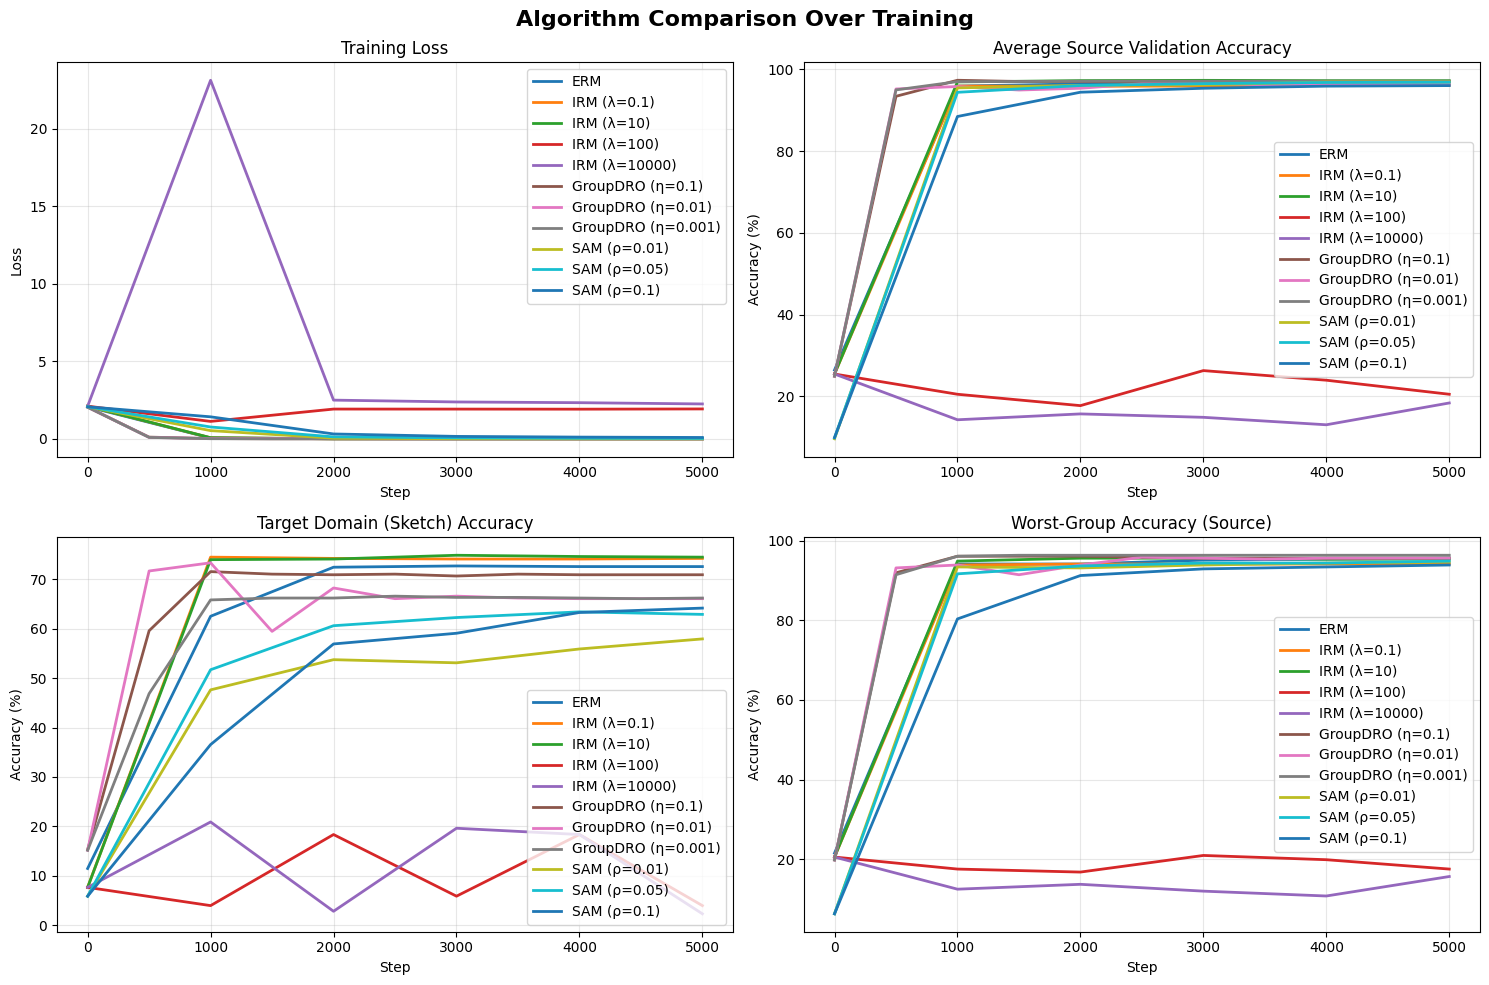


BEST CHECKPOINT SUMMARY
         Algorithm  Best Step Avg Source Val (%) Target Sketch (%) Worst Group (%) Photo (%) Art (%) Cartoon (%)
               ERM       5000              97.01             72.61           95.60     95.60   97.22       98.20
       IRM (λ=0.1)       4000              96.13             74.14           94.13     94.13   96.37       97.90
        IRM (λ=10)       3000              97.32             74.90           95.60     95.60   97.86       98.50
       IRM (λ=100)       3000              26.28              5.86           20.94     23.47   20.94       34.43
     IRM (λ=10000)          0              25.44              7.64           20.54     20.54   24.36       31.44
  GroupDRO (η=0.1)       1000              97.34             71.59           96.09     96.09   97.44       98.50
 GroupDRO (η=0.01)       2500              96.51             66.11           95.84     95.84   96.37       97.31
GroupDRO (η=0.001)       2000              97.12             66.24     

In [12]:
def load_results_jsonl(filepath):
    """Load results from a JSONL file into a pandas DataFrame."""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return pd.DataFrame(results)

def plot_training_metrics(df, model_name, save_path=None):
    """Plot training metrics over time."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} Training Metrics', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss over time
    axes[0, 0].plot(df['step'], df['loss'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Source domain accuracies
    axes[0, 1].plot(df['step'], df['env0_out_acc'] * 100, label='Photo', linewidth=2)
    axes[0, 1].plot(df['step'], df['env1_out_acc'] * 100, label='Art Painting', linewidth=2)
    axes[0, 1].plot(df['step'], df['env2_out_acc'] * 100, label='Cartoon', linewidth=2)
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Source Domain Validation Accuracies')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Target domain accuracy
    axes[1, 0].plot(df['step'], df['env3_out_acc'] * 100, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Target Domain (Sketch) Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Average source accuracy and worst-group accuracy
    df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    df['worst_group_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
    
    axes[1, 1].plot(df['step'], df['avg_source_acc'] * 100, label='Avg Source', linewidth=2)
    axes[1, 1].plot(df['step'], df['worst_group_acc'] * 100, label='Worst Group', linewidth=2)
    axes[1, 1].plot(df['step'], df['env3_out_acc'] * 100, label='Target (Sketch)', linewidth=2)
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Aggregated Metrics')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def get_best_checkpoint_info(df):
    """Get information about the best checkpoint based on average source validation accuracy."""
    df['avg_source_val_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    best_idx = df['avg_source_val_acc'].idxmax()
    best_row = df.iloc[best_idx]
    
    return {
        'step': int(best_row['step']),
        'epoch': best_row['epoch'],
        'avg_source_val_acc': best_row['avg_source_val_acc'] * 100,
        'target_acc': best_row['env3_out_acc'] * 100,
        'photo_acc': best_row['env0_out_acc'] * 100,
        'art_acc': best_row['env1_out_acc'] * 100,
        'cartoon_acc': best_row['env2_out_acc'] * 100,
        'worst_group_acc': min(best_row['env0_out_acc'], best_row['env1_out_acc'], best_row['env2_out_acc']) * 100,
        'loss': best_row['loss']
    }

def compare_algorithms_over_time(results_dict):
    """Compare multiple algorithms' performance over training."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Algorithm Comparison Over Training', fontsize=16, fontweight='bold')
    
    for algo_name, df in results_dict.items():
        df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
        df['worst_group_acc'] = df[['env0_out_acc', 'env1_out_acc', 'env2_out_acc']].min(axis=1)
        
        # Plot loss
        axes[0, 0].plot(df['step'], df['loss'], label=algo_name, linewidth=2)
        
        # Plot average source accuracy
        axes[0, 1].plot(df['step'], df['avg_source_acc'] * 100, label=algo_name, linewidth=2)
        
        # Plot target accuracy
        axes[1, 0].plot(df['step'], df['env3_out_acc'] * 100, label=algo_name, linewidth=2)
        
        # Plot worst-group accuracy
        axes[1, 1].plot(df['step'], df['worst_group_acc'] * 100, label=algo_name, linewidth=2)
    
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Average Source Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Target Domain (Sketch) Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Worst-Group Accuracy (Source)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
# Compare multiple algorithms
print("\n" + "="*80)
print("COMPARING ALL ALGORITHMS")
print("="*80)

results_dict = {
    'ERM': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/erm_training/results.jsonl'),
    'IRM (λ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_0.1_penalty/results.jsonl'),
    'IRM (λ=10)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10_penalty/results.jsonl'),
    'IRM (λ=100)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_100_penalty/results.jsonl'),
    'IRM (λ=10000)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/irm_training_10000_penalty/results.jsonl'),
    'GroupDRO (η=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.1_eta/results.jsonl'),
    'GroupDRO (η=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.01_eta/results.jsonl'),
    'GroupDRO (η=0.001)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/gdro_training_0.001_eta/results.jsonl'),
    'SAM (ρ=0.01)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.01_rho/results.jsonl'),
    'SAM (ρ=0.05)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.05_rho/results.jsonl'),
    'SAM (ρ=0.1)': load_results_jsonl('/home/csalt/Haider/ATML/ATML-PA 2/DomainBed/sam_training_0.1_rho/results.jsonl')
}

compare_algorithms_over_time(results_dict)

# Create summary table of best checkpoints
print("\n" + "="*80)
print("BEST CHECKPOINT SUMMARY")
print("="*80)

summary_data = []
for algo_name, df in results_dict.items():
    best_info = get_best_checkpoint_info(df)
    summary_data.append({
        'Algorithm': algo_name,
        'Best Step': best_info['step'],
        'Avg Source Val (%)': f"{best_info['avg_source_val_acc']:.2f}",
        'Target Sketch (%)': f"{best_info['target_acc']:.2f}",
        'Worst Group (%)': f"{best_info['worst_group_acc']:.2f}",
        'Photo (%)': f"{best_info['photo_acc']:.2f}",
        'Art (%)': f"{best_info['art_acc']:.2f}",
        'Cartoon (%)': f"{best_info['cartoon_acc']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Analyze convergence behavior
print("\n" + "="*80)
print("CONVERGENCE ANALYSIS")
print("="*80)

for algo_name, df in results_dict.items():
    # Check if target accuracy improves in later training
    early_target_acc = df.iloc[:len(df)//3]['env3_out_acc'].mean() * 100
    late_target_acc = df.iloc[2*len(df)//3:]['env3_out_acc'].mean() * 100
    
    print(f"\n{algo_name}:")
    print(f"  Early training target acc (first 1/3): {early_target_acc:.2f}%")
    print(f"  Late training target acc (last 1/3): {late_target_acc:.2f}%")
    print(f"  Improvement: {late_target_acc - early_target_acc:+.2f}%")
    
    # Check for overfitting (source acc increases but target acc decreases)
    df['avg_source_acc'] = (df['env0_out_acc'] + df['env1_out_acc'] + df['env2_out_acc']) / 3
    source_trend = df['avg_source_acc'].iloc[-1] - df['avg_source_acc'].iloc[len(df)//2]
    target_trend = df['env3_out_acc'].iloc[-1] - df['env3_out_acc'].iloc[len(df)//2]
    
    if source_trend > 0 and target_trend < 0:
        print(f"  ⚠️ Potential overfitting detected in second half of training")
    elif source_trend > 0 and target_trend > 0:
        print(f"  ✓ Healthy generalization in second half of training")

In [ ]:
def measure_sharpness(model, dataloader, epsilon=0.01, num_directions=10):
    """
    Measure sharpness by perturbing model parameters and checking loss increase.
    
    Args:
        model: The trained model
        dataloader: DataLoader to compute loss on
        epsilon: Perturbation magnitude
        num_directions: Number of random directions to sample
    
    Returns:
        Dictionary with sharpness metrics
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get original loss
    original_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            original_loss += F.cross_entropy(outputs, labels).item()
            num_batches += 1
    original_loss /= num_batches
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
    # Sample random directions and measure loss increase
    loss_increases = []
    
    for _ in range(num_directions):
        # Generate random direction
        with torch.no_grad():
            for p in model.parameters():
                if p.requires_grad:
                    # Random perturbation with same shape as parameter
                    perturbation = torch.randn_like(p) * epsilon
                    p.add_(perturbation)
        
        # Compute perturbed loss
        perturbed_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for images, labels, _ in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                perturbed_loss += F.cross_entropy(outputs, labels).item()
                num_batches += 1
        perturbed_loss /= num_batches
        
        loss_increases.append(perturbed_loss - original_loss)
        
        # Restore original parameters for next iteration
        with torch.no_grad():
            for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
                p.copy_(orig_p)
    
    # Restore original parameters
    with torch.no_grad():
        for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
            p.copy_(orig_p)
    
    return {
        'original_loss': original_loss,
        'mean_loss_increase': np.mean(loss_increases),
        'max_loss_increase': np.max(loss_increases),
        'std_loss_increase': np.std(loss_increases),
        'sharpness': np.mean(loss_increases) / original_loss  # Normalized sharpness
    }
    
def measure_cross_domain_flatness(model, domain_loaders, epsilon=0.01, num_directions=10):
    """
    Measure cross-domain flatness: perturbations that hurt one domain should hurt all.
    
    Returns correlation between loss increases across domains.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get original losses for each domain
    original_losses = {}
    for domain_name, loader in domain_loaders.items():
        loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for images, labels, _ in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss += F.cross_entropy(outputs, labels).item()
                num_batches += 1
        original_losses[domain_name] = loss / num_batches
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
    # Track loss increases per domain for each perturbation
    domain_increases = {domain: [] for domain in domain_loaders.keys()}
    
    for _ in range(num_directions):
        # Apply same random perturbation
        with torch.no_grad():
            for p in model.parameters():
                if p.requires_grad:
                    perturbation = torch.randn_like(p) * epsilon
                    p.add_(perturbation)
        
        # Measure loss increase for each domain
        for domain_name, loader in domain_loaders.items():
            perturbed_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for images, labels, _ in loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    perturbed_loss += F.cross_entropy(outputs, labels).item()
                    num_batches += 1
            perturbed_loss /= num_batches
            
            domain_increases[domain_name].append(perturbed_loss - original_losses[domain_name])
        
        # Restore parameters
        with torch.no_grad():
            for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
                p.copy_(orig_p)
    
    # Restore original parameters
    with torch.no_grad():
        for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
            p.copy_(orig_p)
    
    # Compute correlation matrix between domain loss increases
    domain_names = list(domain_loaders.keys())
    increases_array = np.array([domain_increases[d] for d in domain_names])
    correlation_matrix = np.corrcoef(increases_array)
    
    return {
        'domain_increases': domain_increases,
        'correlation_matrix': correlation_matrix,
        'mean_correlation': np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]),
        'original_losses': original_losses
    }
    
def compute_loss_landscape_2d(model, dataloader, direction1, direction2, 
                               alpha_range=(-1, 1), beta_range=(-1, 1), 
                               steps=20):
    """
    Compute 2D loss landscape by moving in two random directions.
    
    Args:
        model: The model to analyze
        dataloader: Data to compute loss on
        direction1, direction2: List of parameter perturbations (same structure as model params)
        alpha_range, beta_range: Range for each direction
        steps: Number of points to sample in each direction
    
    Returns:
        alphas, betas, losses (meshgrid for plotting)
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Store original parameters
    original_params = [p.clone() for p in model.parameters() if p.requires_grad]
    
    # Create grid
    alphas = np.linspace(alpha_range[0], alpha_range[1], steps)
    betas = np.linspace(beta_range[0], beta_range[1], steps)
    losses = np.zeros((len(betas), len(alphas)))
    
    # Compute loss at each grid point
    for i, beta in enumerate(betas):
        for j, alpha in enumerate(alphas):
            # Perturb parameters: θ = θ_0 + α*d1 + β*d2
            with torch.no_grad():
                for p, orig_p, d1, d2 in zip([p for p in model.parameters() if p.requires_grad], 
                                              original_params, direction1, direction2):
                    p.copy_(orig_p + alpha * d1 + beta * d2)
            
            # Compute loss
            loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for images, labels, _ in dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss += F.cross_entropy(outputs, labels).item()
                    num_batches += 1
                    if num_batches >= 10:  # Limit batches for speed
                        break
            losses[i, j] = loss / num_batches
    
    # Restore original parameters
    with torch.no_grad():
        for p, orig_p in zip([p for p in model.parameters() if p.requires_grad], original_params):
            p.copy_(orig_p)
    
    return alphas, betas, losses

def generate_random_directions(model, num_directions=2):
    """Generate random directions for loss landscape visualization."""
    directions = []
    for _ in range(num_directions):
        direction = []
        for p in model.parameters():
            if p.requires_grad:
                # Random direction normalized to unit norm
                d = torch.randn_like(p)
                d = d / torch.norm(d)
                direction.append(d)
        directions.append(direction)
    return directions

def visualize_loss_landscape(model, dataloader, model_name="Model", 
                             alpha_range=(-0.5, 0.5), beta_range=(-0.5, 0.5), 
                             steps=20):
    """
    Create 2D visualization of loss landscape.
    """
    print(f"Computing loss landscape for {model_name}...")
    
    # Generate two random directions
    directions = generate_random_directions(model, num_directions=2)
    direction1, direction2 = directions[0], directions[1]
    
    # Compute landscape
    alphas, betas, losses = compute_loss_landscape_2d(
        model, dataloader, direction1, direction2,
        alpha_range, beta_range, steps
    )
    
    # Plot
    fig = plt.figure(figsize=(14, 5))
    
    # 3D surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(alphas, betas)
    surf = ax1.plot_surface(X, Y, losses, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Direction 1 (α)')
    ax1.set_ylabel('Direction 2 (β)')
    ax1.set_zlabel('Loss')
    ax1.set_title(f'{model_name} - Loss Surface')
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    
    # Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, losses, levels=20, cmap='viridis')
    ax2.contour(X, Y, losses, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax2.plot(0, 0, 'r*', markersize=15, label='Current solution')
    ax2.set_xlabel('Direction 1 (α)')
    ax2.set_ylabel('Direction 2 (β)')
    ax2.set_title(f'{model_name} - Loss Contours')
    ax2.legend()
    fig.colorbar(contour, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    return alphas, betas, losses

# Load best models
print("Loading best models for flatness analysis...")

# ERM
erm_resnet_pacs.load_state_dict(torch.load('best_erm_resnet.pth'))
# SAM
sam_resnet_pacs.load_state_dict(torch.load('best_sam_resnet.pth'))

print("\n" + "="*80)
print("FLATNESS ANALYSIS")
print("="*80)

# 1. Measure sharpness on validation set
print("\n1. SINGLE-DOMAIN SHARPNESS (Validation Set)")
print("-" * 80)

erm_sharpness = measure_sharpness(erm_resnet_pacs, pacs_val_loader, epsilon=0.01, num_directions=20)
sam_sharpness = measure_sharpness(sam_resnet_pacs, pacs_val_loader, epsilon=0.01, num_directions=20)

print(f"\nERM Model:")
print(f"  Original Loss: {erm_sharpness['original_loss']:.4f}")
print(f"  Mean Loss Increase: {erm_sharpness['mean_loss_increase']:.4f}")
print(f"  Max Loss Increase: {erm_sharpness['max_loss_increase']:.4f}")
print(f"  Std Loss Increase: {erm_sharpness['std_loss_increase']:.4f}")
print(f"  Normalized Sharpness: {erm_sharpness['sharpness']:.4f}")

print(f"\nSAM Model:")
print(f"  Original Loss: {sam_sharpness['original_loss']:.4f}")
print(f"  Mean Loss Increase: {sam_sharpness['mean_loss_increase']:.4f}")
print(f"  Max Loss Increase: {sam_sharpness['max_loss_increase']:.4f}")
print(f"  Std Loss Increase: {sam_sharpness['std_loss_increase']:.4f}")
print(f"  Normalized Sharpness: {sam_sharpness['sharpness']:.4f}")

print(f"\n➤ SAM achieves {(erm_sharpness['sharpness'] / sam_sharpness['sharpness']):.2f}x flatter minimum!")

# 2. Cross-domain flatness
print("\n2. CROSS-DOMAIN FLATNESS")
print("-" * 80)

# Create domain loaders for measurement
domain_loaders_dict = {
    'photo': pacs_photo_loader,
    'art_painting': pacs_art_painting_loader,
    'cartoon': pacs_cartoon_loader
}

erm_cross_flatness = measure_cross_domain_flatness(
    erm_resnet_pacs, domain_loaders_dict, epsilon=0.01, num_directions=20
)
sam_cross_flatness = measure_cross_domain_flatness(
    sam_resnet_pacs, domain_loaders_dict, epsilon=0.01, num_directions=20
)

print(f"\nERM Model:")
print(f"  Mean Cross-Domain Correlation: {erm_cross_flatness['mean_correlation']:.4f}")
print(f"  Correlation Matrix:")
print(erm_cross_flatness['correlation_matrix'])

print(f"\nSAM Model:")
print(f"  Mean Cross-Domain Correlation: {sam_cross_flatness['mean_correlation']:.4f}")
print(f"  Correlation Matrix:")
print(sam_cross_flatness['correlation_matrix'])

# Visualize correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(erm_cross_flatness['correlation_matrix'], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('ERM - Cross-Domain Loss Correlation')
axes[0].set_xticks(range(3))
axes[0].set_yticks(range(3))
axes[0].set_xticklabels(['photo', 'art', 'cartoon'])
axes[0].set_yticklabels(['photo', 'art', 'cartoon'])
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(sam_cross_flatness['correlation_matrix'], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('SAM - Cross-Domain Loss Correlation')
axes[1].set_xticks(range(3))
axes[1].set_yticks(range(3))
axes[1].set_xticklabels(['photo', 'art', 'cartoon'])
axes[1].set_yticklabels(['photo', 'art', 'cartoon'])
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\n➤ Higher correlation = better cross-domain flatness (perturbations hurt all domains equally)")

# 3. Visualize loss landscapes
print("\n3. LOSS LANDSCAPE VISUALIZATION")
print("-" * 80)

# Use a subset of validation data for speed
val_subset_size = 500
val_subset_indices = torch.randperm(len(pacs_val_split))[:val_subset_size]
val_subset = torch.utils.data.Subset(pacs_val_split, val_subset_indices)
val_subset_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

print("\nVisualizing ERM loss landscape...")
erm_alphas, erm_betas, erm_losses = visualize_loss_landscape(
    erm_resnet_pacs, val_subset_loader, model_name="ERM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)

print("\nVisualizing SAM loss landscape...")
sam_alphas, sam_betas, sam_losses = visualize_loss_landscape(
    sam_resnet_pacs, val_subset_loader, model_name="SAM",
    alpha_range=(-0.3, 0.3), beta_range=(-0.3, 0.3), steps=25
)

# Compare flatness: compute average gradient magnitude around minimum
print("\n4. QUANTITATIVE COMPARISON")
print("-" * 80)

def compute_local_curvature(losses):
    """Compute average absolute gradient magnitude around center."""
    center_i, center_j = losses.shape[0] // 2, losses.shape[1] // 2
    gradients = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            i, j = center_i + di, center_j + dj
            if 0 <= i < losses.shape[0] and 0 <= j < losses.shape[1]:
                gradients.append(abs(losses[i, j] - losses[center_i, center_j]))
    return np.mean(gradients)

erm_curvature = compute_local_curvature(erm_losses)
sam_curvature = compute_local_curvature(sam_losses)

print(f"ERM Local Curvature: {erm_curvature:.4f}")
print(f"SAM Local Curvature: {sam_curvature:.4f}")
print(f"➤ SAM has {(erm_curvature / sam_curvature):.2f}x flatter local region!")